# Reference 

https://www.kaggle.com/code/andradaolteanu/pytorch-rnns-and-lstms-explained-acc-0-99/notebook

In [ ]:
import pandas as pd
import numpy as np
import os
from mpl_toolkits.mplot3d import Axes3D
import math
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
import random
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
File="/content/drive/My Drive/Colab Notebooks/Deep Learning  - Sem 2/Assignment 4/Dataset/Handwritten"

In [ ]:
def readData(Folder,file):
    data=pd.read_csv(Folder+"/"+str(file)+".txt"," ",header=None)
    data=np.array(data.values)
    return data

In [ ]:
def loadData(image_path,train_test):
    char = []
    y =[]
    
    for filename in os.listdir(image_path):
      char_path = os.path.join(image_path, filename)
      path = os.path.join(char_path, 'train')
      for file_txt in os.listdir(path):
        file_path = os.path.join(path, file_txt)
        # print(file_path)
        ch = pd.read_csv(file_path, header = None)
        A = str(ch.values[0]).split(' ')
        # print(A[1:-2])
        A = np.array(A[1:-2]).astype(np.float32)
        B = A[1:-2].reshape((-1,2))
        min_x = np.min(B,axis=0)
        max_x = np.max(B,axis=0)
        B = (B-min_x)/(max_x - min_x)
        
        char.append(B)
        y.append(filename)

    label=[]
    for z in y:
        if z=='a':
            label.append([1,0,0,0,0])
        if z=='bA':
            label.append([0,1,0,0,0])
        if z=='dA':
            label.append([0,0,1,0,0])
        if z=='tA':
            # print('dA')
            label.append([0,0,0,1,0])
        if z=='lA':
            # print('lA')
            label.append([0,0,0,0,1])
        
            
    charater, label = char, np.array(label).astype(np.float32)

    return charater, label

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/Deep Learning  - Sem 2/Assignment 4/Dataset/Handwritten"

In [ ]:
train, label = loadData(path,'/train/')

In [ ]:
np.array(train).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(342,)

In [ ]:
len(label)

342

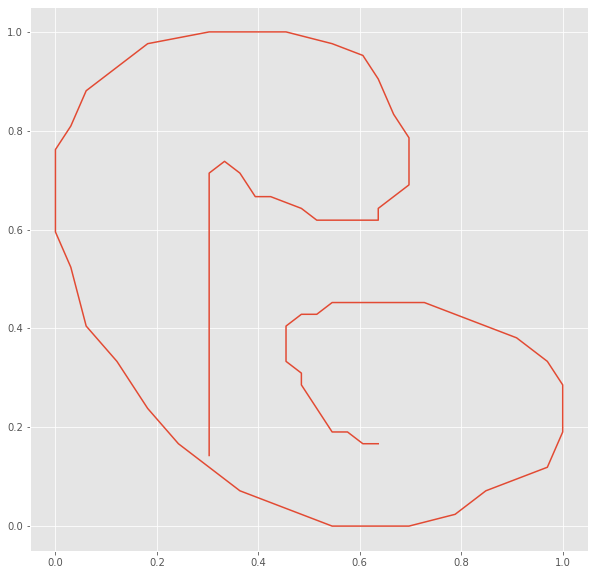

In [ ]:
plt.plot(train[10][:,0],train[10][:,1])

In [ ]:
class RNN_Char(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super(RNN_Char, self).__init__()
        
        self.input_size, self.hidden_size, self.layer_size, self.output_size = input_size, hidden_size, layer_size, output_size
        
        # Step1: the RNN model
        self.rnn = nn.RNN(input_size, hidden_size)
        self.layer = nn.Linear(hidden_size, output_size)
        self.soft = nn.Softmax(dim=0)
            
            
    def forward(self, images, prints=False):
        if prints: print('images shape:', images.shape)  
          
        # RNN:
        output, _ = self.rnn(images)
        if prints: print('RNN: output shape:', output.shape, '\n')
        
        # FNN:
        output = self.layer(output[-1])
        output =self.soft(output)
        if prints: print('FNN: Final output shape:', output.shape)
        
        return output

In [ ]:
input_size = 2      
hidden_size = 120   # number of hidden neurons
layer_size = 3        # number of layers
output_size = 5      # possible choices

In [ ]:
# Instantiate the model
# We'll use TANH as our activation function
rnn_rnn = RNN_Char(input_size, hidden_size, layer_size, output_size)

In [1]:
## Basic
# input = torch.from_numpy(train[10])
# output=rnn_rnn(input)
# output

Text(0.5, 1.0, 'Error vs Epoch')

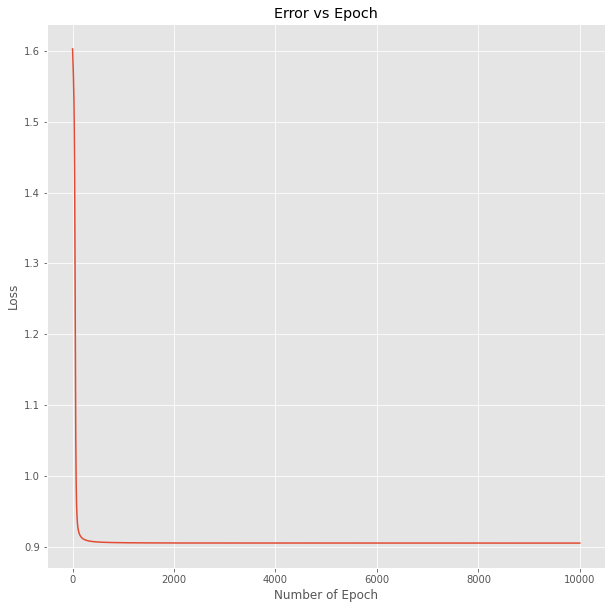

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_rnn.parameters(), lr=0.0001)
losss =[]
epoch = 10000
preloss=0
confusion_matrix = np.zeros((5, 5))

for j in range(epoch):
  train_loss=0
  for i in range(len(train)-1):

    A = train[i]
    A = A.astype(np.float32)
    input =torch.from_numpy(A)
    l = label[i]
    l = l.astype(np.float32)
    l=np.argmax(l)
    lbl  =torch.tensor(l)
    optimizer.zero_grad()
    output=rnn_rnn(input)
    
    # print(output)
    # print(lbl)

    loss = criterion(input=output, target =lbl)
    loss.backward()
    # Updates the weights
    optimizer.step()
    
    # Save Loss & Accuracy after each iteration
    train_loss += loss.item()
    losss.append(train_loss)
    preloss = train_loss

    if abs(preloss-train_loss)<=10e-4:
      break
    
  # Print Average Train Loss & Accuracy after each epoch
  # print('TRAIN | Epoch: {}/{} | Loss: {:.2f} |'.format(j+1, epoch, train_loss))

  #Confusion Matrix
  pre = torch.argmax(output).item()
  act = lbl.item()
  
  if pre == act :
    confusion_matrix[act][act]+=1
  else:
    confusion_matrix[act][pre]+=1

plt.plot(losss)
plt.xlabel("Number of Epoch")
plt.ylabel("Loss")
plt.title("Error vs Epoch")

In [ ]:
# Confusion Matrix
Acc = np.trace(confusion_matrix)
Total = np.sum(confusion_matrix)
Acc = 100* Acc/Total
print('Accuracy: ',Acc)
print(confusion_matrix)

Accuracy:  99.99
[[9.999e+03 0.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]]
